# Rossmann Store Sales Forecasting - Store 1

This notebook builds a SARIMAX model to forecast daily sales for Store 1, incorporating weekly seasonality and the effects of promotions and holidays.

In [1]:
# ## 1. Setup and Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import math

# Set plotting styles
sns.set(style='darkgrid')
plt.rcParams['figure.figsize'] = (14, 7) # Slightly larger default plots

## 2. Load and Prepare Data
Load `train.csv` and `store.csv`, merge them, handle the date format, filter for Store 1, remove closed days, and set the date as the index.

In [2]:
# Load the datasets
try:
    train_df = pd.read_csv('../data/train.csv', low_memory=False)
    store_df = pd.read_csv('../data/store.csv')
except FileNotFoundError:
    print("Error: train.csv or store.csv not found in the '../data/' folder.")
    # Handle error appropriately

# Merge, convert date, sort
df = pd.merge(train_df, store_df, on='Store')
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', inplace=True)

# Filter for Store 1 and open days, then set index
store_id = 1
df_store = df[(df['Store'] == store_id) & (df['Sales'] > 0)].copy()
df_store.set_index('Date', inplace=True)

print(f"Data prepared for Store {store_id}. Shape: {df_store.shape}")
df_store.head()

Data prepared for Store 1. Shape: (781, 17)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
Date,,,,,,,,,,,,,,,,,
2013-01-02,1,3,5530,668,1,0,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2013-01-03,1,4,4327,578,1,0,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2013-01-04,1,5,4486,619,1,0,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2013-01-05,1,6,4997,635,1,0,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2013-01-07,1,1,7176,785,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


## 3. Exploratory Data Analysis (EDA) & Seasonality Check
Visualize the sales data to identify trends and seasonality. We'll check for weekly patterns specifically.

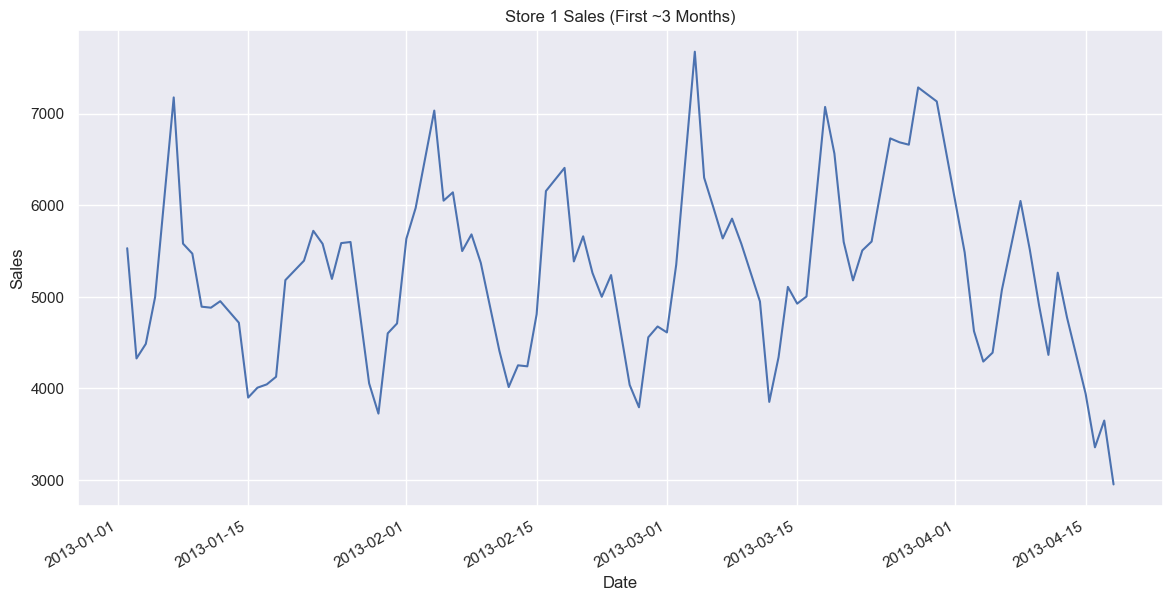

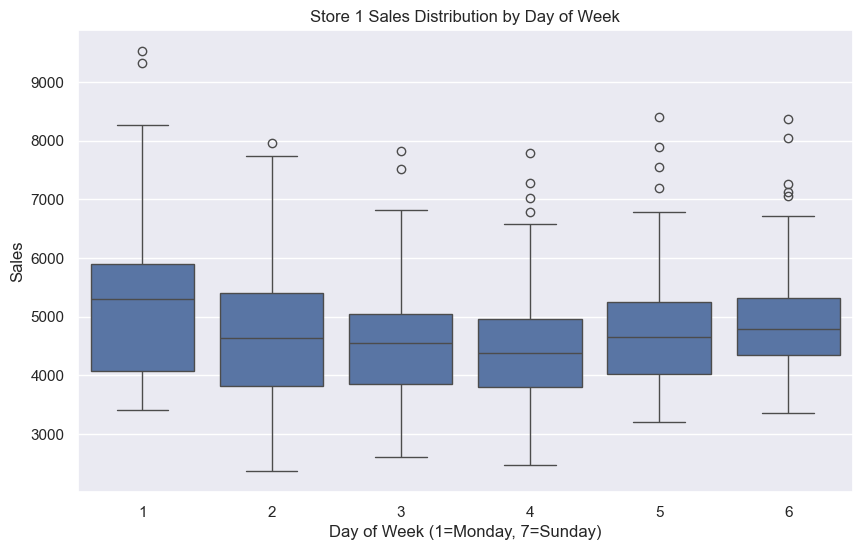

<Figure size 1200x600 with 0 Axes>

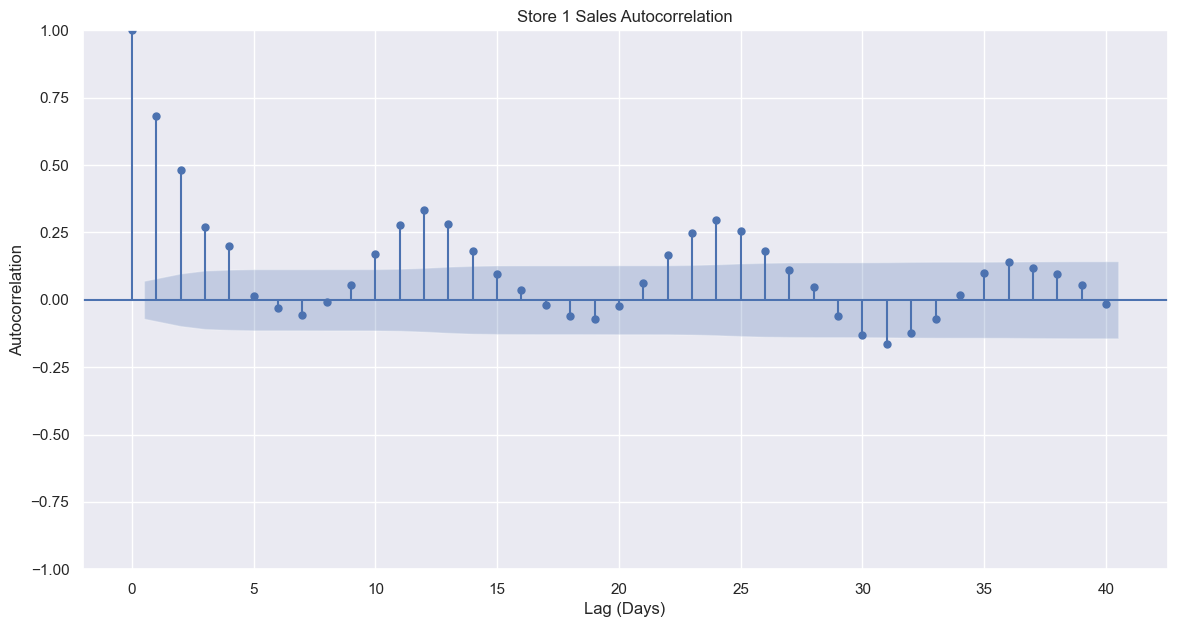

In [3]:
# Plot sales over time (zoomed view)
df_store['Sales'].iloc[:90].plot() # Plot first ~3 months
plt.title(f'Store {store_id} Sales (First ~3 Months)')
plt.ylabel('Sales')
plt.xlabel('Date')
plt.show()

# Box plot by day of week
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_store, x='DayOfWeek', y='Sales')
plt.title(f'Store {store_id} Sales Distribution by Day of Week')
plt.xlabel('Day of Week (1=Monday, 7=Sunday)')
plt.ylabel('Sales')
plt.show()

# Autocorrelation Function (ACF) plot
plt.figure(figsize=(12, 6))
plot_acf(df_store['Sales'], lags=40, title=f'Store {store_id} Sales Autocorrelation')
plt.xlabel('Lag (Days)')
plt.ylabel('Autocorrelation')
plt.show()

**EDA Analysis:**
- The time series plot shows clear fluctuations.
- The box plot confirms sales patterns differ significantly by the day of the week (highest on Monday, lower mid-week).
- The ACF plot shows **strong peaks at lags 7, 14, 21, etc.**, confirming a **7-day weekly seasonality**.
- The ACF plot also shows **slow decay** for the initial lags, suggesting **non-stationarity** and the likely need for differencing (`d=1`).

## 4. Feature Engineering
Prepare the target variable (`y` = Sales) and exogenous variables (`X` = Promo, SchoolHoliday). StateHoliday is handled, though not present for Store 1 on open days. Ensure `X` is numeric.

In [4]:
# --- Feature Engineering ---
model_df = df_store.copy()

# Handle StateHoliday (convert '0' string, then one-hot encode)
model_df['StateHoliday'] = model_df['StateHoliday'].replace('0', 0)
model_df['StateHoliday'] = model_df['StateHoliday'].replace(0, 'NoHoliday')
model_df = pd.get_dummies(model_df, columns=['StateHoliday'], drop_first=True)

# Define target variable 'y'
y = model_df['Sales']

# Define exogenous variables 'X'
state_holiday_cols = [col for col in model_df.columns if col.startswith('StateHoliday_')]
exog_cols = ['Promo', 'SchoolHoliday'] + state_holiday_cols
X = model_df[exog_cols]

# Convert X to integer type for statsmodels compatibility
X = X.astype(int)

print("Exogenous variables (X) head:")
print(X.head())

Exogenous variables (X) head:
            Promo  SchoolHoliday
Date                            
2013-01-02      0              1
2013-01-03      0              1
2013-01-04      0              1
2013-01-05      0              1
2013-01-07      1              1


/var/folders/1y/pn9x7lqd0vj4j9d589w2jl1r0000gn/T/ipykernel_15383/3538748325.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  model_df['StateHoliday'] = model_df['StateHoliday'].replace('0', 0)


## 5. Train/Test Split
Split data sequentially into training (past) and testing (recent future) sets.

In [5]:
test_period = 30
train_size = len(y) - test_period

y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]
X_train = X.iloc[:train_size]
X_test = X.iloc[train_size:]

print(f"Training data: {len(y_train)} points")
print(f"Test data:     {len(y_test)} points")

Training data: 751 points
Test data:     30 points


## 6. Model Selection & Training
**Model Selection Rationale:**
- Initial attempts with `auto_arima` suggested complex `d=0` models (e.g., `(3,0,4)`), but these **failed to converge** during training.
- Analysis of failed `d=0` models revealed an `ar.L1` coefficient near 1.0, indicating a **unit root (non-stationarity)**.
- The **correct fix** for a unit root is **differencing (d=1)**.
- We manually specified a stable `d=1` model incorporating the weekly seasonality (`m=7`). Attempts to add yearly features (like month dummies) conflicted with `d=1` and worsened performance significantly.
- Therefore, the final model uses `d=1` and focuses on weekly seasonality and exogenous regressors.

In [6]:
# --- Train the Final Stable Model ---
# Orders: (p=1, d=1, q=1) and seasonal (P=0, D=0, Q=1, m=7)
my_order = (1, 1, 1)
my_seasonal_order = (0, 0, 1, 7)

# Create and fit the SARIMAX model
final_model = sm.tsa.SARIMAX(
    endog=y_train,
    exog=X_train,
    order=my_order,
    seasonal_order=my_seasonal_order
)
model_fit = final_model.fit(disp=False)

print("Final Model Summary:")
print(model_fit.summary())

/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Final Model Summary:
                                     SARIMAX Results                                     
Dep. Variable:                             Sales   No. Observations:                  751
Model:             SARIMAX(1, 1, 1)x(0, 0, 1, 7)   Log Likelihood               -5981.452
Date:                           Wed, 22 Oct 2025   AIC                          11974.904
Time:                                   21:45:32   BIC                          12002.625
Sample:                                        0   HQIC                         11985.586
                                           - 751                                         
Covariance Type:                             opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Promo           578.9064     65.438      8.847      0.000     450.650     707.163
SchoolHoliday

**Model Summary Analysis:**
- The model converged successfully. AIC is relatively low (~11975).
- `Promo` is highly significant (p < 0.001), positively impacting sales changes.
- `SchoolHoliday` is not significant for this store in this model (p=0.141).
- The AR, MA, and Seasonal MA terms are significant, capturing the time series dynamics.

## 7. Forecasting & Evaluation
Generate forecasts on the test set and evaluate performance using plots and metrics (RMSE and RMSPE).

/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


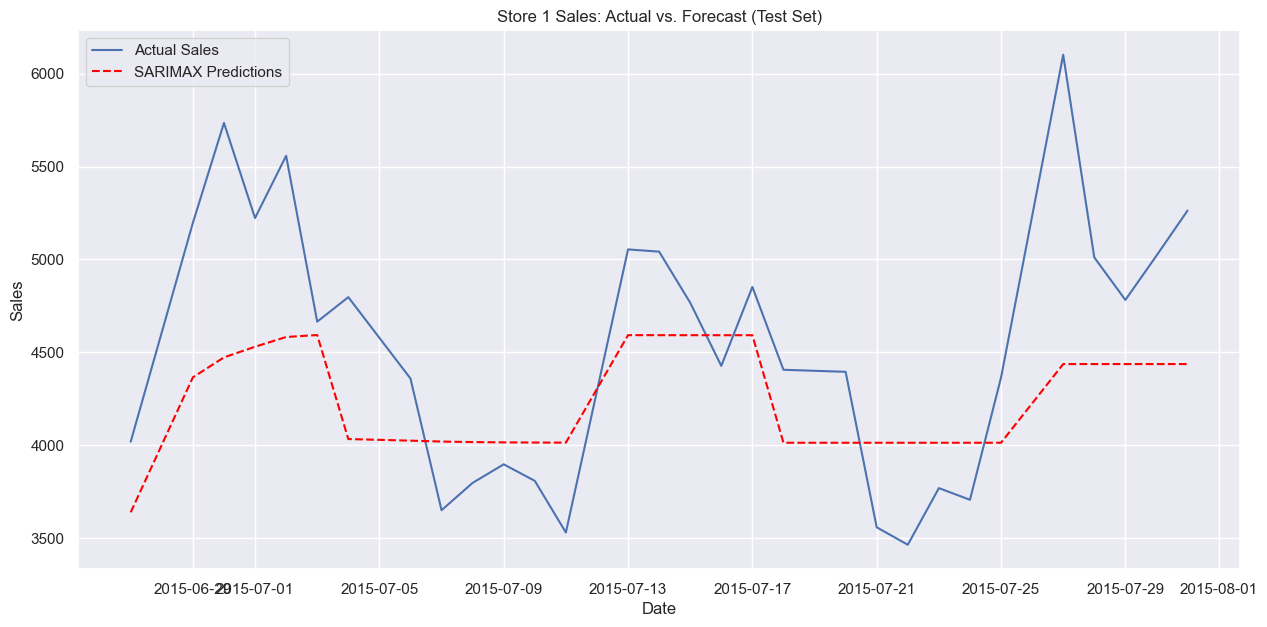

Model Accuracy (RMSE): 603.03
Model Accuracy (RMSPE): 11.92%


In [7]:
# --- Forecasting ---
num_steps = len(y_test)
predictions = model_fit.forecast(steps=num_steps, exog=X_test)
predictions = predictions.rename('SARIMAX Predictions')

# --- Evaluation ---
# Fix index for plotting
try:
    predictions.index = y_test.index
except ValueError as e:
    print(f"Error setting prediction index: {e}")

# Plot actual vs. predicted
plt.figure(figsize=(15, 7))
plt.plot(y_test, label='Actual Sales')
plt.plot(predictions, label='SARIMAX Predictions', color='red', linestyle='--')
plt.title(f'Store {store_id} Sales: Actual vs. Forecast (Test Set)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Calculate metrics
rmse = math.sqrt(mean_squared_error(y_test, predictions))
# Ensure no zero division for RMSPE
y_test_safe = y_test.replace(0, np.nan).dropna()
predictions_safe = predictions[y_test_safe.index]
rmspe = np.sqrt(np.mean(((y_test_safe - predictions_safe) / y_test_safe) ** 2))

print(f"Model Accuracy (RMSE): {rmse:.2f}")
print(f"Model Accuracy (RMSPE): {rmspe * 100:.2f}%")

**Evaluation Analysis:**
- The plot shows the forecast captures the general weekly pattern, though it smooths out the daily noise.
- The RMSPE of **~11.92%** is a strong result, indicating the model is reasonably accurate for this store.